# Лабораторная работа № 1

## Постановка задачи

Необходимо реализовать методы Монте-Карло: *метод проб и ошибок*, *выборочное среднее*, *взвешенное среднее*; Для каждого метода найти 
- погрешность $\varepsilon$ вычисления;
- построить график зависимости погрешности $\varepsilon$ от объема выборки $N$ в лог-лог масштабе;
- выявить функцилнальную зависимость $\varepsilon$ при $N \rightarrow \infty$;
- сравнить полученные результаты с методами *Трапеций* и *Симпсона* по точности и временной эффективности.

Для методов *выборочное среднее* и *взвешенное среднее* найти и сравнить дисперсии.

## Входные данные

Все расчеты будут проводиться для следующих функций
$$f(x)=4\sqrt{1 - x^2},$$
$$g(x)=\dfrac{4}{1+x^2},$$


$$x \in [0, 1].$$

Значение определенных интегралов указанных функции можно получить аналитически

$$\int\limits_0^1 4 \sqrt{1 - x^2} dx = \begin{vmatrix} x = \sin{\theta}  \\  dx = \cos{\theta}d\theta\end{vmatrix} = \int\limits_0^{\pi/2} 4 \cos^2{\theta}d\theta = ... = \pi \approx 3.1415926;$$
$$\int\limits_0^1 \frac{4}{1+x^2} dx = \begin{vmatrix} x = \tan{\theta}  \\  dx = \dfrac{d\theta}{\cos{\theta}}\end{vmatrix} = \int\limits_0^{\pi/4} 4 d\theta = ... = \pi \approx 3.1415926.$$

Погрешность вычислений $\varepsilon$ определим как модуль разници между полученным аналитически и приближенным значениями.

In [1]:
#Погрешность вычисления epsilon
def error(tru_value, value):
    return abs(tru_value - value)

## Реализация

In [2]:
#Подключим необходимые библиотеки 
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

from random import random, uniform, seed
from math import sqrt, pi, exp, log, cos, sin, asin

In [3]:
#Итегрируемые функции.
def f(x):
    return 4 * sqrt(1 - x * x)

def g(x):
    return 4 / (1 + x * x)

Построим графики этих функций на указоном интервале.

In [4]:
#Функция для построения оформленного графика
def graph(ax, function, y_label=''):
    
    #Задаем интервал от 0 до 1 с шагом 0.005
    x = np.arange(0, 1.005, 0.005)
    
    ax.plot(x, [function(i) for i in x], c='purple', label=y_label)
    
    ax.set_xlabel('$x$', loc='right', size=20)
    ax.set_ylabel(y_label, rotation=0, loc='top', size=20)
    
    ax.tick_params(labelsize=12)
    
    ax.set_ylim(0, 4.2)
    ax.set_xlim(0, 1)
    
    ax.grid()
    
    plt.tight_layout()

<IPython.core.display.Javascript object>


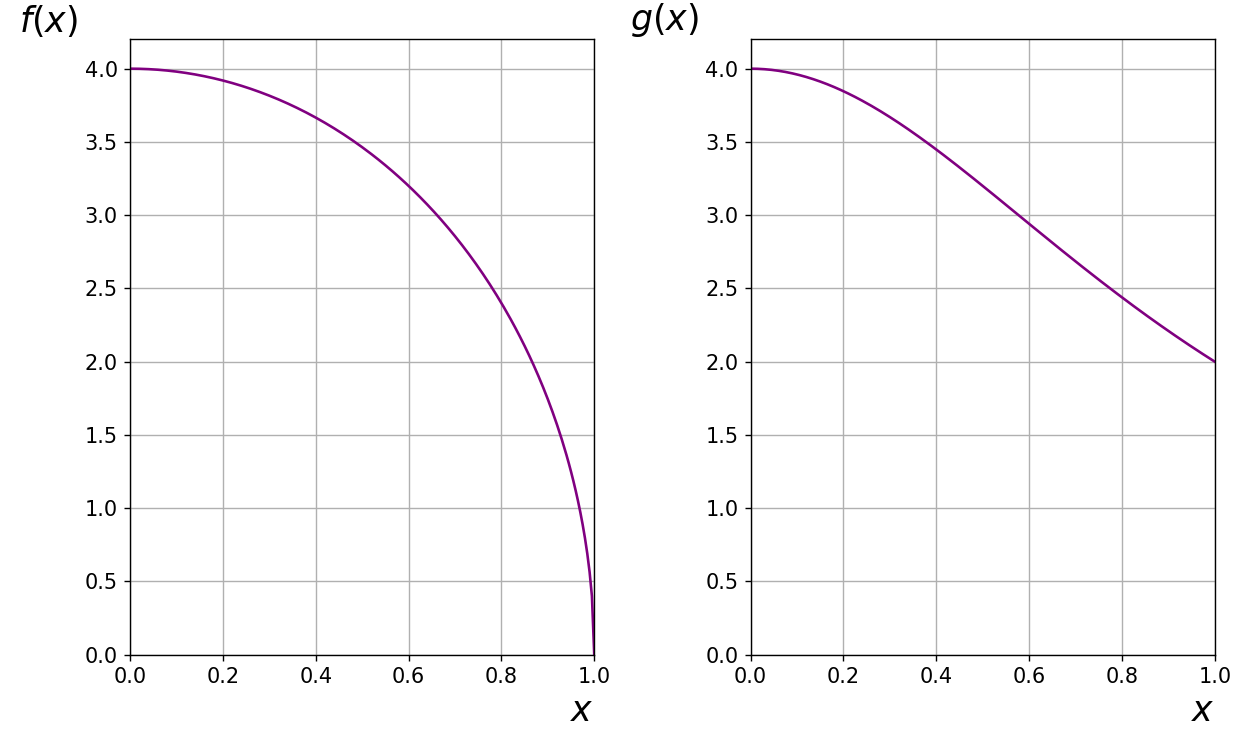

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

graph(ax1, f, '$f(x)$')
graph(ax2, g, '$g(x)$')

#fig.savefig('graphs.svg', format='svg')

Основываясь на виде графиков, попробуем определить весовые функции $\omega$ для функций $f(x)$ и $g(x)$.

Весовая функция должна удовлетворять следующим требованиям

- *$\omega$ должна быть нормирована* $$\int\limits_0^1 \omega(x) dx = 1;$$
- *Характер изменеия весовой функции $\omega$ должен совпадать с интегрируемой функцией*;
- *Возможность нахождения $x(\xi)$* $$\xi(x) = \int\limits_0^x \omega(x^{'}) dx^{'},~\xi(0)=0,~\xi(1)=1.$$

Пусть ненормированые весовые функции имеют следующий вид
$$f(x):~~~ \omega(x) = 4\cos(x\dfrac{5\pi}{13}),$$
$$g(x):~~~ \omega(x) = 4-2x.$$

Сравним вид определенных ненормированных функций с интегрируемыми функциями

<IPython.core.display.Javascript object>


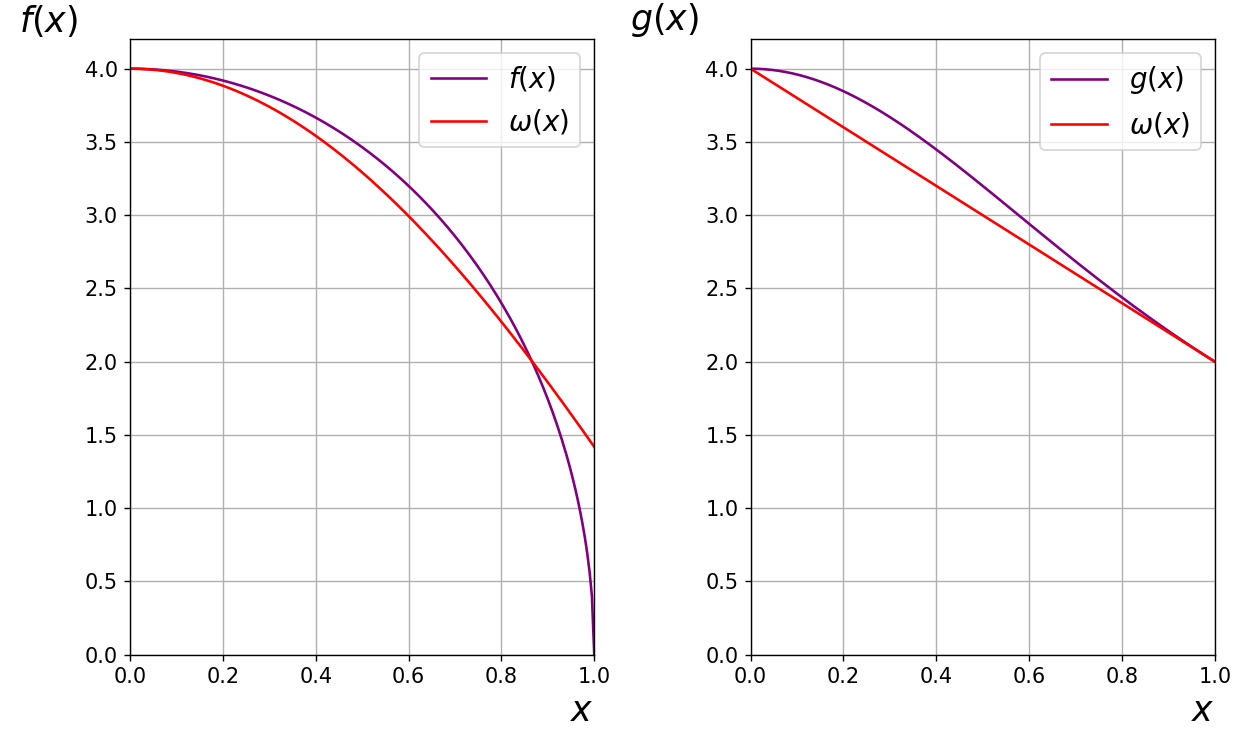

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

graph(ax1, f, '$f(x)$')
graph(ax2, g, '$g(x)$')

x = np.arange(0, 1.005, 0.005)

ax1.plot(x, [4 * cos(i * 5 * pi / 13) for i in x], c='red', label='$\omega(x)$')
ax1.legend(prop={'size': 16})

ax2.plot(x, [4 - 2 * i for i in x], c='red',label='$\omega(x)$')
ax2.legend(prop={'size': 16})

Из полученных графиков видно, что характер изменения функций схож.
После нормировки получим следующие весовые функции
$$f(x):~~~ \omega(x) = \dfrac{5\pi}{13\sin{\dfrac{5\pi}{13}}}\cos(x\dfrac{5\pi}{13}),$$


$$g(x):~~~ \omega(x) = \frac{2}{3}(2-x).$$

Для коректной работы метода необходимо найти зависимость $x(\xi)$
$$f(x):~~~ x(\xi)=\frac{13}{5\pi}\arcsin(\xi\sin{\frac{5\pi}{13}}),$$


$$g(x):~~~ x(\xi)=2-\sqrt{4-3\xi}.$$

In [7]:
#Реализация весовых функция и зависимостей x(xi)
def weight_f(x):
    return 5 * pi * cos(x * 5 * pi / 13) / (13 * sin(5 * pi / 13))

def x_f(xi):
    return 13 * asin(xi * sin(5 * pi / 13)) / (5 * pi)


def weight_g(x):
    return 2 * (2 - x) / 3

def x_g(xi):
    return 2 - sqrt(4 - 3 * xi)

Перейдем к непосредственной реализации методов численного интегрирования.

***Метод проб и ошибок***
$$ I = \int\limits_0^1 f(x) dx \approx F \frac{N_f}{N},$$
где $F=maxf(x)$ на $0\leqslant x<1$, $N -$ общее количество точек, $N_f -$ количество точек, для которых $y_i < f(x_i)~~~i=1,N.$

Так как для обеих функций $f(x)$ и $g(x)$ максимально значение на указаном интервале равно $4$, то по умолчанию $F=4$.

***Метод выборочного среднего***
$$ I = \int\limits_0^1 f(x) dx = \langle f \rangle,$$
$$ I = \langle I_{\alpha} \rangle = \frac{1}{M} \sum_{\alpha=1}^M I_{\alpha},$$

где $I_{\alpha} - $ приближенное значение интегралла, $M - $ количество реализаций выборочного среднего.

$$I_{\alpha} = \frac{1}{N} \sum_{i=1}^N f_i.$$

***Метод взвешенного среднего***
$$\int\limits_0^1 f dx =  \int\limits_0^1 \frac{f}{\omega} \omega dx = \begin{vmatrix} \omega dx = d\xi \\ \dfrac{f(x(\xi))}{\omega(x(\xi))} = g(xi) \end{vmatrix} \approx \frac{1}{N} \sum_{i=1}^N g(\xi).$$

In [8]:
# Декоратор используется для общности методов
def decorator(func):
    def new_func(function, N, weight=None, x=None):
        return func(function, N)
    return new_func 

@decorator
def trial_and_error(function, N):
    """
    Реализация метода проб и ошибок
    На вход функия принимает: function (интегрируемая функция), N (объем выборки).
    На выходе функция возвращает значение интеграла.
    Анлогично для других методов.
    """ 
    seed()
    N_f = 0
    
    for _ in range(0, N):
        x = random()
        y = uniform(0.00, 4.00)

        if y < function(x):
            N_f += 1

    return  (4.00 * N_f) / N

In [9]:
@decorator
def sample_average(function, N):
    """Реализация метода выборочного среднего."""
    seed()
    return sum([function(random()) for _ in range(N)]) / N

In [10]:
# Реализация метода взвешенного среднего
def weighted_average(function, N, weight, x):
    """
    Кроме интегрируемой функции (function) и объема выборки (N)
    данный метод принимает на вход весовую функцию (weight) и зависимость x(xi).
    """
    seed()
    
    def g(xi):
        return function(x(xi)) / weight(x(xi))
    
    return sum([g(random()) for _ in range(N)]) / N

### Графики и функциональная зависимость $\varepsilon$ от $N \rightarrow \infty$

Найдем функциональную зависимость погрешности $\varepsilon$ от $N \rightarrow \infty$ для каждого метода.

In [11]:
def simulation(function, total,  method, weight=None, x=None):
    """
    Функция принимает на вход следующие параметры
    function - интегрируемая ф-я,
    total - общее количество запусков указанного метода,
    method - ф-я реализующая метод численнотого интегрирования,
    weight - весовая ф-я, обяхательный параметр для метода
    взыешенного среднего,
    x - ф-я, реализующая зависимость x(xi).
    
    На выход функция возвращает кортеж из двух массивов
    массив значения объемной выборки N и
    массив погрешностей epsilon.
    """
    
    # Созданим набор значений объемной выборки 
    list_n = np.array([int(100 * exp(h / 3)) for h in range(total)])
    
    #Найдем погрешности для каждой выборки
    errors = np.array([error(pi, method(function, i, weight, x)) for i in list_n])

    return list_n, errors

In [12]:
# Наборы данных для функции f(x)
result_trial_and_error_f  = simulation(f, 30, trial_and_error)
result_sample_average_f   = simulation(f, 30, sample_average)
result_weighted_average_f = simulation(f, 30, weighted_average, weight_f, x_f)

In [13]:
# Наборы данных для функции g(x)
result_trial_and_error_g  = simulation(g, 30, trial_and_error)
result_sample_average_g   = simulation(g, 30, sample_average)
result_weighted_average_g = simulation(g, 30, weighted_average, weight_g, x_g)

In [14]:
# Функция для построения графика погрешности в лог-лог масштабе
def graph_error(ax, result, color, title):
    
    ax.loglog(result[0], result[1], 'o-', c=color)
    
    ax.set_ylabel(r'$\varepsilon$', rotation=0, loc='top', size=20)
    ax.set_xlabel('N', loc='right', size=20)
    
    ax.tick_params(labelsize=12)
    
    ax.set(title=title)
    ax.grid()

<IPython.core.display.Javascript object>


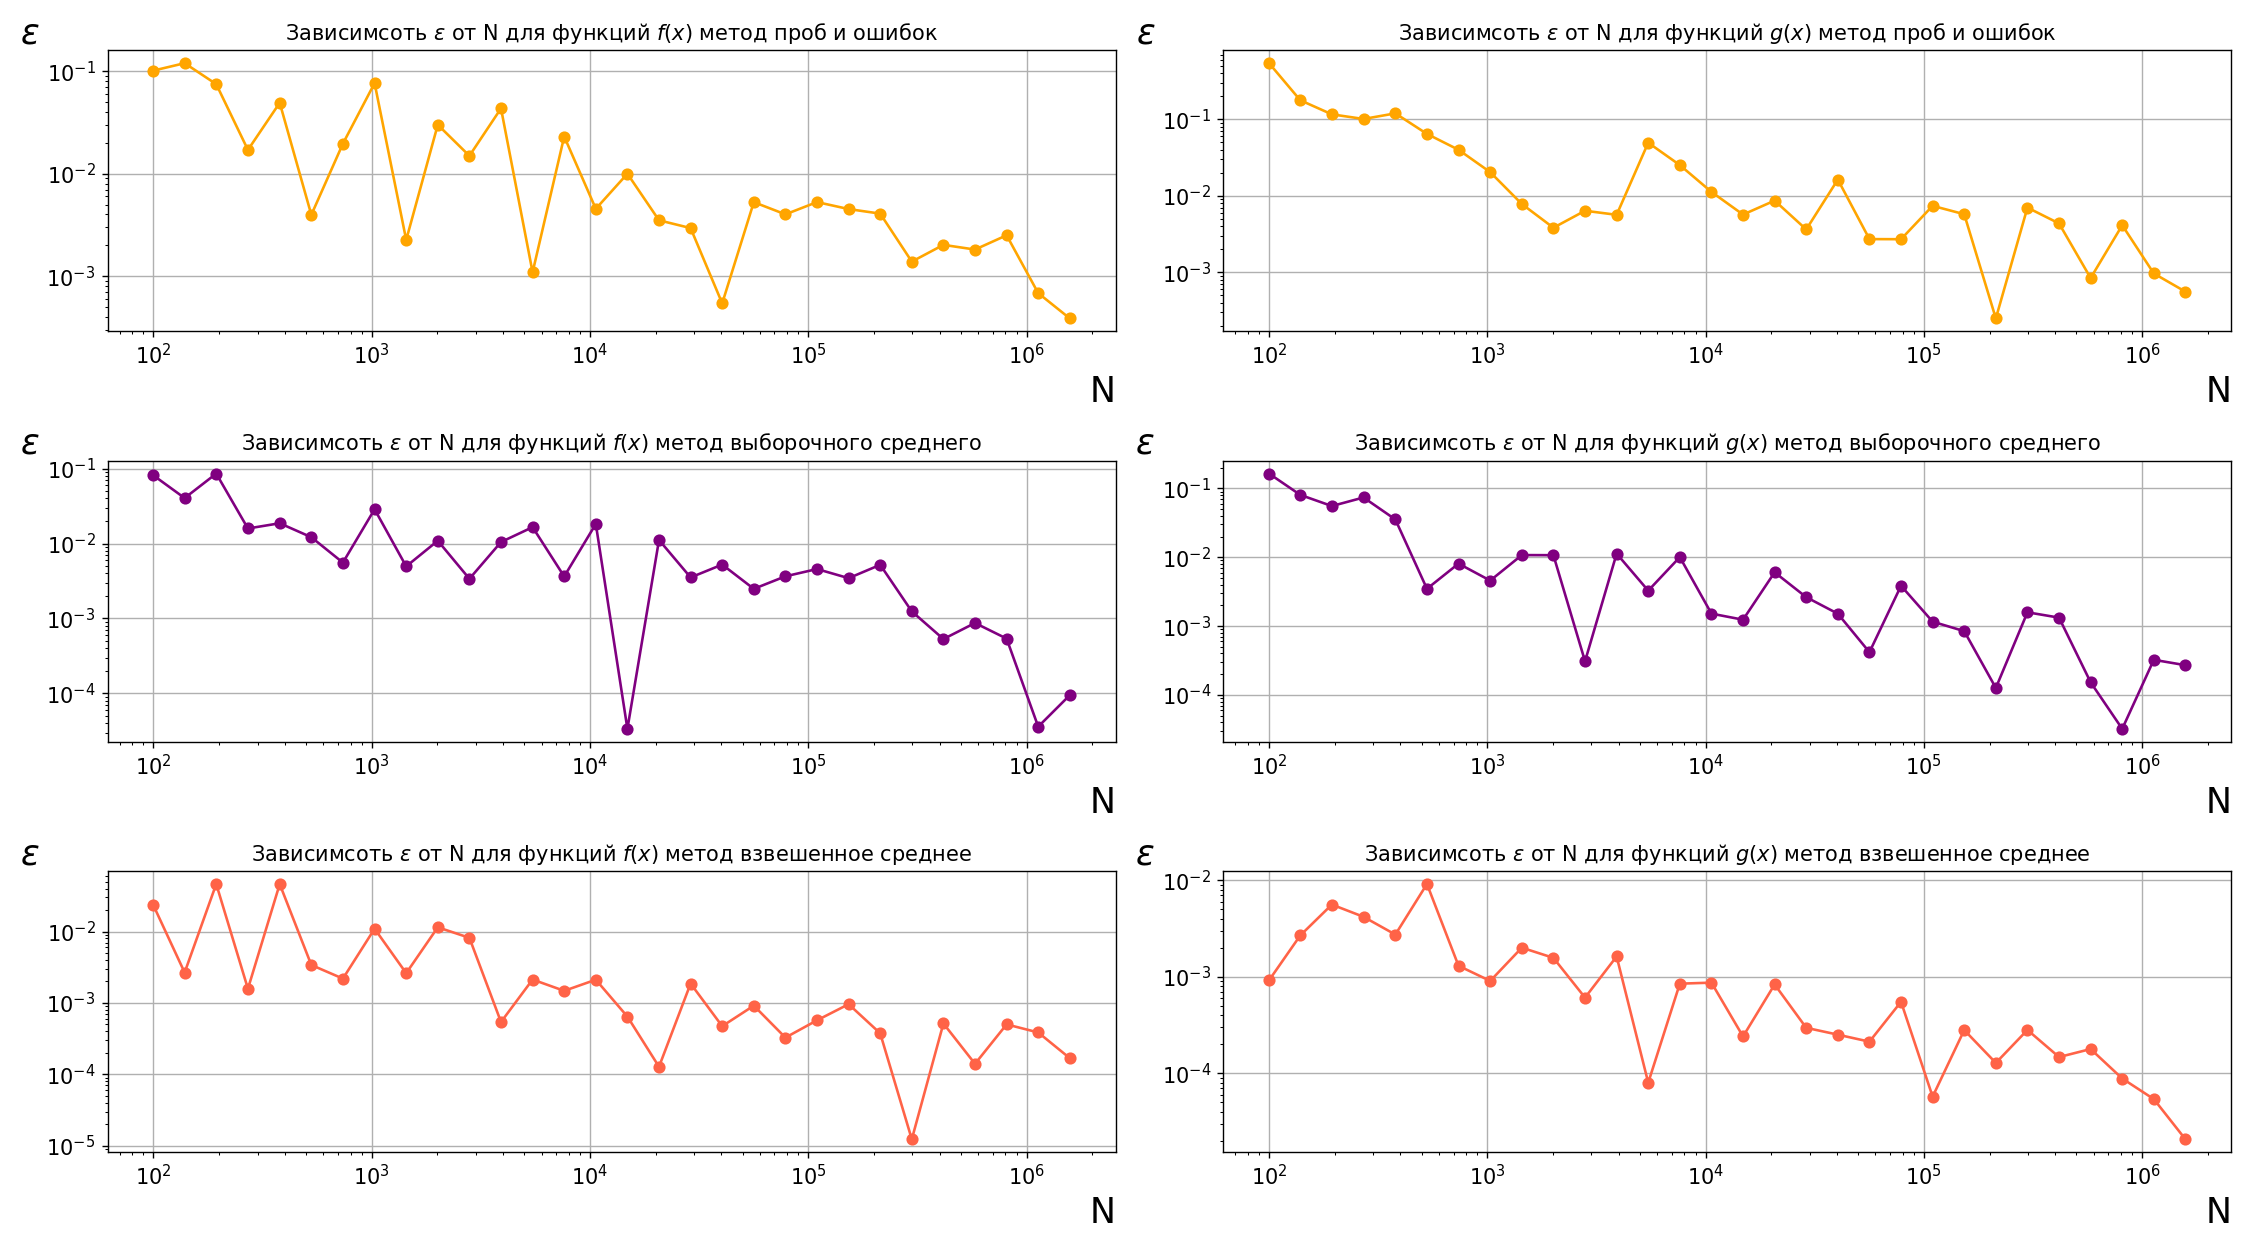

In [15]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 10))

graph_error(axs[0, 0], result_trial_and_error_f, 'orange', r'Зависимсоть $\varepsilon$ от N для функций $f(x)$ метод проб и ошибок')
graph_error(axs[1, 0], result_sample_average_f, 'purple', r'Зависимсоть $\varepsilon$ от N для функций $f(x)$ метод выборочного среднего')
graph_error(axs[2, 0], result_weighted_average_f, '#FF6347', r'Зависимсоть $\varepsilon$ от N для функций $f(x)$ метод взвешенное среднее')

graph_error(axs[0, 1], result_trial_and_error_g, 'orange', r'Зависимсоть $\varepsilon$ от N для функций $g(x)$ метод проб и ошибок')
graph_error(axs[1, 1], result_sample_average_g, 'purple', r'Зависимсоть $\varepsilon$ от N для функций $g(x)$ метод выборочного среднего')
graph_error(axs[2, 1], result_weighted_average_g, '#FF6347', r'Зависимсоть $\varepsilon$ от N для функций $g(x)$ метод взвешенное среднее')

plt.tight_layout()


Из графикоы зависимости $\varepsilon$ от $N$ видно, что зависимость имеет не линейный характер. Предположим, что зависимость подчиняется степенной функции вида
$$f(N) = \beta N^{\alpha},$$
$$ \log(f) = \log(\beta) + \alpha\log(N).$$


Необходимо найти коэффициенты $\alpha$ и $\beta$. Для этого воспользуемся *методом наименьших квадратов*.
$$ F(\alpha, \beta) = \sum_i{(\log(\varepsilon_i) - \log(f))^2},$$
$$ F(\alpha, \beta) = \sum_i{(\log(\varepsilon_i) - \log(\beta) + \alpha\log(N_i))^2} \rightarrow \min.$$
Т.е. частные производные $F$ по $\alpha$ и $\beta$ равны $0$. Откуда
$$ \alpha = \dfrac{n\sum_i^n{\log(\varepsilon_i)\log(N_i)} - \sum_i^n{\log(\varepsilon_i)}\sum_i^n{\log(N_i)}}{n\sum_i^n{(\log(N_i))^2} - (\sum_i^n{\log(N_i))^2}},$$


$$ \log(\beta) = \dfrac{\sum_i^n{\log(\varepsilon_i)} - \alpha\sum_i^n{\log(N_i)}}{n}.$$

In [16]:
# Реализация метода наименьших квадратов
def least_square_method(x, y):
    ln_y = np.log(y)
    ln_x = np.log(x)

    sum_y  = np.sum(ln_y)
    sum_x  = np.sum(ln_x)
    sum_xy = np.sum(ln_y * ln_x)
    sum_xx = np.sum(ln_x * ln_x)
    n = len(x)

    alpha = (n * sum_xy - sum_y * sum_x) / (n * sum_xx - sum_x * sum_x)

    beta = exp((sum_y - alpha * sum_x) / n)

    return alpha, beta

Результаты интегрирования имеют случайный характер, а следовательно и значения погрешности $\varepsilon$. Для более точного определения функциональной зависимости проведем осреднение значений погрешности.
$$ \langle \varepsilon \rangle = \frac{1}{M} \sum_{i=1}^M{\varepsilon_i},$$
где $M -$ число запусков.

Для экономии времени вычисления среднего ограничемся 10 запусками $(M=10)$.

In [17]:
# Подсчет средней пошгрешномти 
def avg_error(function, total, method, weight=None, x=None):

    avg_er = np.zeros(total)
    
    for _ in range(10):
        s = simulation(function, total,  method, weight, x)
        avg_er += s[1]
        
    return s[0], avg_er / 10

In [18]:
# Набор данных для функции f(x)
avg_f_TE = avg_error(f, 30, trial_and_error)
avg_f_SA = avg_error(f, 30, sample_average)
avg_f_WA = avg_error(f, 30, weighted_average, weight_f, x_f)

In [19]:
# Набор данных для функции g(x)
avg_g_TE = avg_error(g, 30, trial_and_error)
avg_g_SA = avg_error(g, 30, sample_average)
avg_g_WA = avg_error(g, 30, weighted_average, weight_g, x_g)

In [20]:
# Вычисления параметров alpha и beta на основе результатов каждого метода
alpha_f_1, beta_f_1 = (least_square_method(avg_f_TE[0], avg_f_TE[1]))
alpha_f_2, beta_f_2 = (least_square_method(avg_f_SA[0], avg_f_SA[1]))
alpha_f_3, beta_f_3 = (least_square_method(avg_f_WA[0], avg_f_WA[1]))

alpha_g_1, beta_g_1 = (least_square_method(avg_g_TE[0], avg_g_TE[1]))
alpha_g_2, beta_g_2 = (least_square_method(avg_g_SA[0], avg_g_SA[1]))
alpha_g_3, beta_g_3 = (least_square_method(avg_g_WA[0], avg_g_WA[1]))

In [21]:
# График для построения ф-ой зависмости погрешности от объема выборки
def graph_functional_dependence(ax, result, alpha, beta, color, title):
    
    ax.loglog(result[0], result[1], 'o-', c=color, label=r'$\varepsilon(N)$')
    ax.loglog(result[0], [beta * pow(x, alpha) for x in result[0]], c='green', \
              label=f'ln({round(beta, 3)})+({round(alpha, 3)})ln(N)')
    
    ax.set_ylabel(r'$\langle \varepsilon \rangle$', rotation=0, loc='top', size=20)
    ax.set_xlabel('N', loc='right', size=20)
    
    ax.tick_params(labelsize=12)
    
    ax.set(title=title)
    ax.grid()
    ax.legend(prop={'size': 15})
    
    plt.tight_layout()

<IPython.core.display.Javascript object>


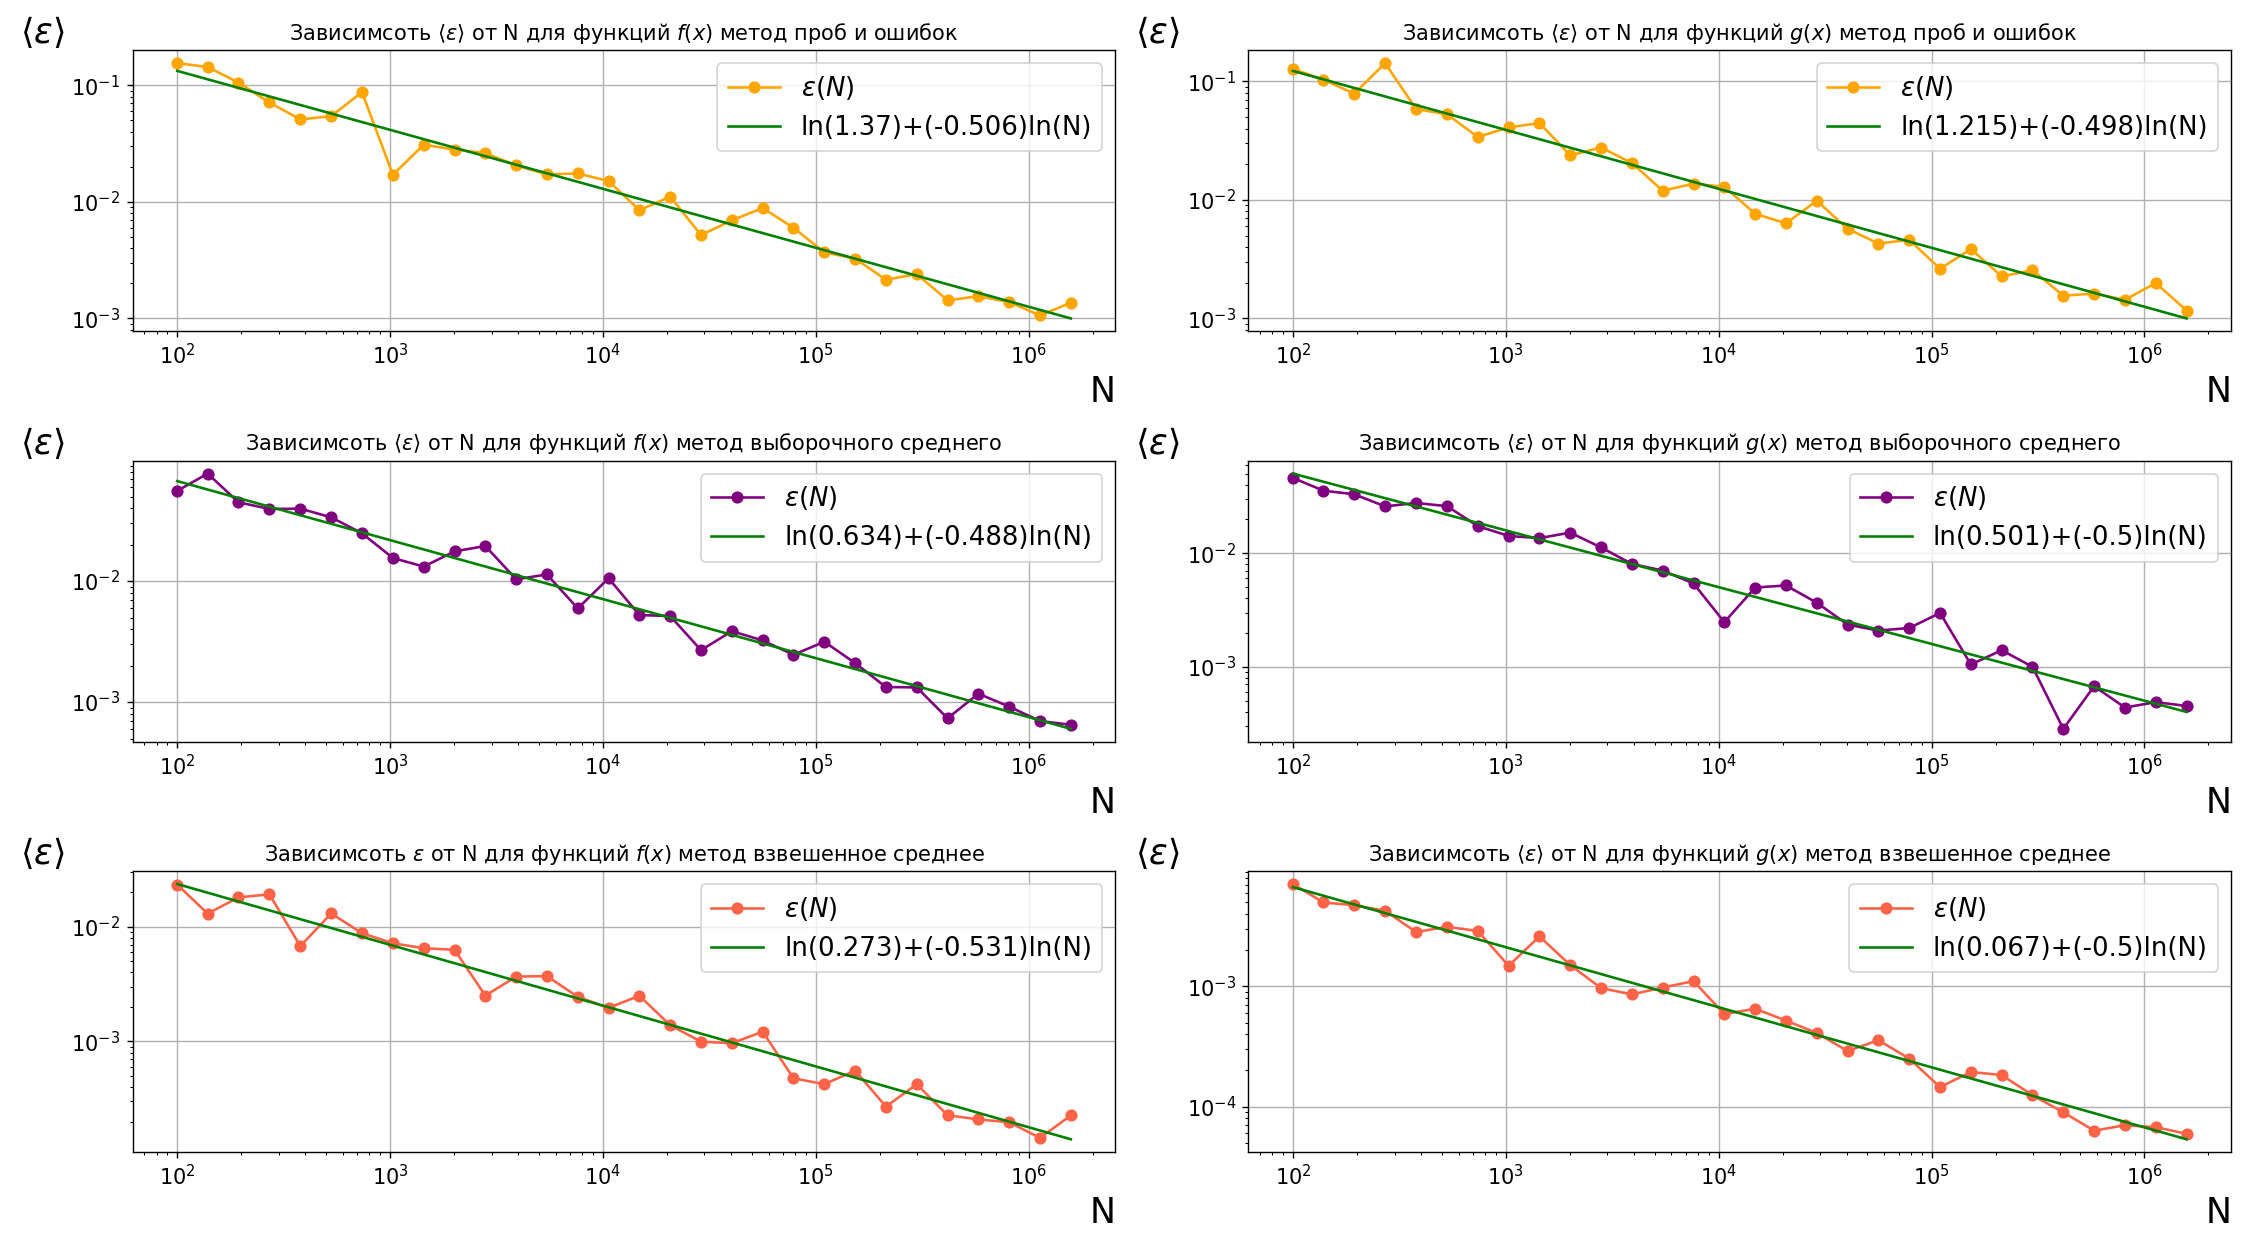

In [22]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 10))

graph_functional_dependence(axs[0, 0], avg_f_TE, alpha_f_1, beta_f_1, 'orange', r'Зависимсоть $\langle \varepsilon \rangle$ от N для функций $f(x)$ метод проб и ошибок')
graph_functional_dependence(axs[1, 0], avg_f_SA, alpha_f_2, beta_f_2, 'purple', r'Зависимсоть $\langle \varepsilon \rangle$ от N для функций $f(x)$ метод выборочного среднего')
graph_functional_dependence(axs[2, 0], avg_f_WA, alpha_f_3, beta_f_3, '#FF6347', r'Зависимсоть $\varepsilon$ от N для функций $f(x)$ метод взвешенное среднее')

graph_functional_dependence(axs[0, 1], avg_g_TE, alpha_g_1, beta_g_1, 'orange', r'Зависимсоть $\langle \varepsilon \rangle$ от N для функций $g(x)$ метод проб и ошибок')
graph_functional_dependence(axs[1, 1], avg_g_SA, alpha_g_2, beta_g_2, 'purple', r'Зависимсоть $\langle \varepsilon \rangle$ от N для функций $g(x)$ метод выборочного среднего')
graph_functional_dependence(axs[2, 1], avg_g_WA, alpha_g_3, beta_g_3, '#FF6347', r'Зависимсоть $\langle \varepsilon \rangle$ от N для функций $g(x)$ метод взвешенное среднее')


С помошью *метода наименьших квадратов* была найдена функциональная зависимость погрешности $\varepsilon$ при $N \rightarrow \infty$ для функций $f(x)$ и $g(x)$. 

Из графиков для усредненной погрешности видно, что фукнциональная зависимость имеет следующий вид
$$ \varepsilon \propto \frac{1}{\sqrt{N}}.$$
Что также поддверждается теоретически.

### Сравнение результатов методов Монте-Карло с методами Трапеций и Симпсона

In [23]:
#Реализации метода Трапеций и Симпсона
@decorator
def trapezium_method(function, N):
    
    step = 1 / N
    x = [i / N for i in range(N + 1)]

    function_i = [function(x_i) for x_i in x]

    integral = 0.5 * sum([(function_i[i] + function_i[i + 1]) * step\
         for i in range(len(x) - 1)])

    return integral
    
    
@decorator
def simpson_method(function, N):

    x = [i / (2 * N) for i in range(2 * N + 1)]
    
    sum1 = 4 * sum([function(x[2 * i - 1]) for i in range(1, N + 1)])
    sum2 = 2 * sum([function(x[2 * i]) for i in range(1, N)])

    return (sum1 + sum2 + function(0) + function(1)) / (3 * 2 * N)

Сравним реализацию методов по погрешностям и затрачиваемому времен для случая $N = 10^{7}$ и $M = 3$.

In [24]:
import time
import pandas as pd

In [25]:
name_methods = {
    simpson_method: 'метод симпсона',
    trapezium_method: 'метод трапеций',
    trial_and_error: 'метод проб и ошибок',
    sample_average: 'выборочное среднее',
    weighted_average: 'взвешенное среднее'
}

In [26]:
# Списки для сохранения результатов
# для дальнейшей передачи в таблицу
list_N = []
methods = []
errors = []
times = []

def clear():
    list_N.clear()
    methods.clear()
    errors.clear()
    times.clear()

In [27]:
# Функция для измерения времени работы метода и его погрешности
def dimension(method, N, func, weight=None, x=None):
    
    start_time = time.time()
    result = method(func, N, weight, x)
    time_ = int((time.time() - start_time) * 1000)
    
    # Сохранение результатов 
    methods.append(name_methods[method])
    errors.append(error(pi, result))
    times.append(time_)
    list_N.append(N)

In [28]:
# Функция для запуска измерений всех методов
def set_dimension(N_list, function, weight, x):
    for N in N_list:
        dimension(simpson_method, N, function)
        dimension(trapezium_method, N, function)
        dimension(trial_and_error, N, function)
        dimension(sample_average, N, function)
        dimension(weighted_average, N, function, weight, x)

In [29]:
clear()
set_dimension([10_000_000, 10_000_000, 10_000_000], f, weight_f, x_f)

# Создание таблицы данных для функции f(x)
df_f = pd.DataFrame({'name method': methods, 'error': errors, 'time [ms]': times, 'N': list_N})

In [30]:
clear()
set_dimension([10_000_000, 10_000_000, 10_000_000], g, weight_g, x_g)

# Создание таблицы данных для функции g(x)
df_g = pd.DataFrame({'name method': methods, 'error': errors, 'time [ms]': times, 'N': list_N})

Выведем полученные результате в виде таблицы

In [31]:
# Для функции f(x) сгрупируем данные по названию метода, усредняя полученные значения
df = df_f.groupby(['name method']).mean()

# Сортировка по убыванию погрешности для функции f(x)
df.sort_values(by=['error'], ascending=False)

,error,time [ms],N
name method,,,
метод проб и ошибок,5.136845e-04,4867.666667,10000000.0
выборочное среднее,1.370823e-04,3066.000000,10000000.0
взвешенное среднее,7.463426e-05,18036.000000,10000000.0
метод трапеций,3.643885e-11,4922.000000,10000000.0
метод симпсона,5.324630e-12,8809.333333,10000000.0


In [32]:
# Сортировка по убыванию времени для функции f(x)
df.sort_values(by=['time [ms]'], ascending=False)

,error,time [ms],N
name method,,,
взвешенное среднее,7.463426e-05,18036.000000,10000000.0
метод симпсона,5.324630e-12,8809.333333,10000000.0
метод трапеций,3.643885e-11,4922.000000,10000000.0
метод проб и ошибок,5.136845e-04,4867.666667,10000000.0
выборочное среднее,1.370823e-04,3066.000000,10000000.0


In [33]:
# Для функции g(x) сгрупируем данные по названию метода и усреднив полученные значения
df_ = df_g.groupby(['name method']).mean()

# Сортировка по убыванию погрешности для функции g(x)
df_.sort_values(by=['error'], ascending=False)

,error,time [ms],N
name method,,,
метод проб и ошибок,2.136488e-04,4126.000000,10000000.0
выборочное среднее,1.943263e-04,2220.000000,10000000.0
взвешенное среднее,1.476573e-05,9691.333333,10000000.0
метод трапеций,6.394885e-13,4237.000000,10000000.0
метод симпсона,2.309264e-14,7572.000000,10000000.0


In [34]:
# Сортировка по убыванию времени для функции g(x)
df_.sort_values(by=['time [ms]'], ascending=False)

,error,time [ms],N
name method,,,
взвешенное среднее,1.476573e-05,9691.333333,10000000.0
метод симпсона,2.309264e-14,7572.000000,10000000.0
метод трапеций,6.394885e-13,4237.000000,10000000.0
метод проб и ошибок,2.136488e-04,4126.000000,10000000.0
выборочное среднее,1.943263e-04,2220.000000,10000000.0


### Дисперсии для методов выборочного и взвешенного среднего

Найдем дисперсию как $$\sigma_f^2 = \langle f^2 \rangle - \langle f \rangle^2.$$

In [35]:
# Подсчет дисперсии для метода выборочного среднего
def dispersion_SA(function, N, M):
    seed()
    
    f_2_list = []
    f_list = []
    
    for _ in range(N * M):
        x = random()
        f_2_list.append(pow(function(x), 2))
        f_list.append(function(x))
    
    return  sum(f_2_list) / (N * M) - pow(sum(f_list) / (N * M), 2)


# Подсчет дисперсии для метода взыешенного среднего
def dispersion_WA(function, N, M, weight, x):
    seed()
    
    def g(xi):
        return function(x(xi)) / weight(x(xi))
    
    g_2_list = []
    g_list = []
    
    for _ in range(N * M):
        xi = random()
        g_2_list.append(pow(g(xi), 2))
        g_list.append(g(xi))
    
    return  sum(g_2_list) / (N * M) - pow(sum(g_list) / (N * M), 2)

In [36]:
print('Для f(x)')
print(f'дисперсия метода выборочного среднего: {dispersion_SA(f, 1_000_000, 3)}')
print(f'дисперсия метода взвешенного среднего: {dispersion_WA(f, 1_000_000, 3, weight_f, x_f)}')

Для f(x)
дисперсия метода выборочного среднего: 0.7985188852053575
дисперсия метода взвешенного среднего: 0.07582460286407766


In [37]:
print('Для g(x)')
print(f'дисперсия метода выборочного среднего: {dispersion_SA(g, 1_000_000, 3)}')
print(f'дисперсия метода взвешенного среднего: {dispersion_WA(g, 1_000_000, 3, weight_g, x_g)}')

Для g(x)
дисперсия метода выборочного среднего: 0.41360384335175127
дисперсия метода взвешенного среднего: 0.006405127425100687


## Выводы

Для данных функций $f(x)$ и $g(x)$ наиболее точными методами численного интегрирования являются *метод Трапеций* и *метод Симпсона*.

Порядок погрешности для *метода трапеций*
$$\varepsilon_f (N = 10^7) = 10^{-11},$$
$$\varepsilon_g (N = 10^7) = 10^{-13}.$$

Для *метода Симпсона*
$$\varepsilon_f (N = 10^7) = 10^{-12},$$
$$\varepsilon_g (N = 10^7) = 10^{-14}.$$

Для методов Монте-Карло
$$\varepsilon_f (N = 10^7) \geqslant 10^{-5},$$
$$\varepsilon_g (N = 10^7) \geqslant 10^{-5}.$$

Для большого объема выборки $(N > 10^6)$ оказываются не самыми эффективными по временным затратам, уступая методу *выборочного среднего* для обеих функций. Но большая разница в порядке значений погрешностей позволяет уменьшить объем выборки, а следовательно и временные затраты методов.

Таким образом, для численного интегрирования данных функций наиболее подходящими методами являются *метод Трапеций* и *метод Симпсона*.

Сравним методы Монте-Карло.

Лучшую точность для обеих функций обеспечивает метод *взвешенного среднего*. Но также являясь самым медленным из всех представленных методов, так как кроме значения самой функции, необходимо вычислять взвешенную функцию и функцию $x(\xi)$. 

Значения временной эффективности указаны в таблицах в пункте **Сравнение результатов методов Монте-Карло с методами Трапеций и Симпсона**, и могут сильно отличаться взависимости от технических характеристик ПК, поэтой причине неуказаны в данном разделе.

Порядок погрешности для *взвешенного среднего*
$$\varepsilon_f (N = 10^7) = 10^{-5},$$
$$\varepsilon_g (N = 10^7) = 10^{-5}.$$

Для *выборочного среднего*
$$\varepsilon_f (N = 10^7) = 10^{-4},$$
$$\varepsilon_g (N = 10^7) = 10^{-4}.$$

Для *метод проб и ошибок*
$$\varepsilon_f (N = 10^7) = 10^{-4},$$
$$\varepsilon_g (N = 10^7) = 10^{-4}.$$

*Выборочное среднее* и *метод проб и ошибок* имееют одинаковый порядок погрешностей, но первый метод показывает лучшую временную эффективность из всех рассматриваемых методов. Что делает *выборочное среднее* более предпочтительным методом.

Рассмотрим дисперсии *взвешенного среднего* и *выборочного среднего*. Для функции $f(x)$ дисперсии отличаются на один порядок, в то время как для функции $g(x)$ дисперсии отличаются на два порядка. Такая разница дисперсий между методами объясняется наличием весовых функций в *взвешенном среднем*. В рамках метода *взвешенного среднего* разница порядков дисперсий для функций $f(x)$ и $g(x)$, учитывая одинаковый порядок значений дисперсий в методе *выборочного среднего*, указывает на то, что качество весовых функций не одинаково. В данном случае, для $f(x)$ имеет смысл найти другую весовую функцию, имеющую более схожий характер изменения.

Учитывая выше сказанное, самым подходящим методом Монте-Карло для интегрированеи функций $f(x)$ и $g(x)$ является метод *выборочного среднего*
- показывает лучшую временную эффективность, даже с учтом  методов Трапеций и Симпсона,
- не требует нахождения весовых функций и зависимости $x(\xi)$.